# Machine Translation with Seq2seq models via Pytorch

The goal of this lab are to:
- Familiarize yourself with the task of **Machine Translation (MT)**
- Implement a basic **recurrent sequence-to-sequence** model in Pytorch
- Train the model on a very simple English-French MT dataset
- Implement an **attention** module into the model and visualize its results

We will **for most of this lab** focus on the model and leave aside what are normally very important aspects of Machine Learning methodology: in particular, we won't use validation and test data to search for hyperparameter search. We will **split the data and retrain the model at the end of the lab** for a comparative performance evaluation.

In [ ]:
# General stuff
from io import open
import re
import unicodedata
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

# Nice printing
from pprint import pprint

# Pytorch
import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# Which device to use ?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### I Dataset and pre-processing

We're going to work with data from the **tatoeba** website. This website proposes human-made translations for many (relatively) simple sentences, with sometimes several possible translations for one sentence.
Pre-processed versions of the *tatoeba dataset* can be found on this [website](https://www.manythings.org/anki/). You are given the 'English $\rightarrow$ French' data already cleaned, but you are free to use any other language you would prefer.  


<div class='alert alert-block alert-warning'>
            Question:</div>
            
We will define these as global variables - for convenience. Given what was said in class and how they are employed in this lab, explain briefly what each one is used for.

In [ ]:
# Some global variables
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2

From the previous pytorch lab, we know we will require to define some parameters. We can already choose the maximum length of sequences, the size of our batches, and the internal dimension used by our model. Note that the length of sequence is rather short in this data - you can take a look at the histogram.

**Put ```fra.txt``` in the current directory**.

In [ ]:
# Parameters
max_length = 10
batch_size = 32
hidden_size = 128

In [ ]:
# Read the file and split into lines
parallel = open('fra.txt', encoding='utf-8').\
        read().strip().split('\n')

In [ ]:
# Data looks like this
pprint(parallel[0:5])

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & '
 '#1158250 (Wittydev)',
 'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & '
 '#8090732 (Micsmithel)',
 'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & '
 '#8267435 (felix63)',
 'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & '
 '#9022935 (Micsmithel)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & '
 '#509819 (Aiji)']


We will need to clean this up. Use the regular expression package ```re``` to remove any non letter character. Be careful, though, with French, you need to keep the accents. We will then organize the data into pairs, as is usual in MT.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    # Convert to lowercase
    s = s.lower().strip()

    # Normalize unicode (decomposed form)
    s = unicodedata.normalize('NFD', s)

    # Keep only French letters, accents, apostrophes, and ligatures
    s = re.sub(r"[^a-zA-ZÀ-ÖØ-öø-ÿœæ']", " ", s)

    # Normalize back to NFC (composed form)
    s = unicodedata.normalize('NFC', s)

    # Remove multiple spaces
    s = re.sub(r"\s+", " ", s).strip()

    return s

In [ ]:
# Split every line into pairs and normalize
pairs = []
for line in parallel:
    parts = line.strip().split("\t")  # Split into parts
    if len(parts) >= 2:  # Ensure at least two elements (English & French)
        eng, fra = normalizeString(parts[0]), normalizeString(parts[1])  # Take only the first two columns
        if eng and fra:  # Ensure they are not empty
            pairs.append([eng, fra])

print(f"Total valid pairs after metadata removal: {len(pairs)}")

Total valid pairs after metadata removal: 232736


In [ ]:
pprint(pairs[0:5])

[['go', 'va'],
 ['go', 'marche'],
 ['go', 'en route'],
 ['go', 'bouge'],
 ['hi', 'salut']]


Begin with implementing a class ```Vocab``` that will accumulate counts and indexes of words into language-specific dictionnaries. In this case, we would like the vocabulary to be built on the fly, to work well with the format of our data (parallel sentences from both languages).

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class Vocab:
    def __init__(self):
        self.word2count = {}
        self.word2idx = {"SOS": SOS_TOKEN, "EOS": EOS_TOKEN}
        self.idx2word = {SOS_TOKEN: "SOS", EOS_TOKEN: "EOS"}

    # Implemented assuming we will process lines one by one, easier given the format of our data
    def addSent(self, sent):
        for word in sent.split():  # Tokenizing sentence
            if word not in self.word2idx:
                idx = len(self.word2idx)  # New word index
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                self.word2count[word] = 1
            else:
                self.word2count[word] += 1

    def __len__(self):
        return len(self.word2idx)

Then, create a function ```tensorFromSentence``` that will take an untokenized sentence (hence, a string), a ```Vocab``` object, and the ```max_length``` parameter as inputs, and return a ```LongTensor``` representing the sequence of indexes.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def tensorFromSentence(sent, vocab, max_length):
    indexes = [vocab.word2idx.get(word, vocab.word2idx.get('<UNK>', 0)) for word in sent.split()]
    indexes = [SOS_TOKEN] + indexes + [EOS_TOKEN]  # Add SOS and EOS tokens

    if len(indexes) > max_length:
        indexes = indexes[:max_length - 1] + [EOS_TOKEN]  # Ensure EOS is included

    return torch.tensor(indexes, dtype=torch.long, device=device)

Finally, complete this ```TranslationDataset``` class inheriting from ```Dataset```. It should, from the list of parallel sentences:
- Apply an optional filter to possibly reduce the dataset size and complexity,
- Instantiate and build ```Vocab``` objects for both languages,
- Create two lists containing ```LongTensor``` objects for each language,
- Group them into two tensors of the appropriate size with ```pad_sequence```.

You should note that, depending on the ordering of the pairs, one language will be the **source**, and the other will be the **target** of our model. In this case, English is the source and French the target.
<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, parallel_data, max_length = 10, filter_target_prefixes = None):
        # We will select some subset on the data to avoid having too much
        self.pairs = self.filterData(parallel_data, filter_target_prefixes)
        # Creating both vocabularies
        self.max_length = max_length
        self.input_lang = Vocab() # English
        self.output_lang = Vocab()  # French
        # Filling both vocabularies
        for pair in self.pairs:
            self.input_lang.addSent(pair[0])  # English sentence
            self.output_lang.addSent(pair[1])  # French sentence
        # List of tensors to be created
        self.tensor_inputs = [tensorFromSentence(pair[0], self.input_lang, max_length) for pair in self.pairs]
        self.tensor_outputs = [tensorFromSentence(pair[1], self.output_lang, max_length) for pair in self.pairs]
        # Put them all at the same size with pad_sequence
        self.tensor_inputs = pad_sequence(self.tensor_inputs, batch_first=True, padding_value=PAD_TOKEN)
        self.tensor_outputs = pad_sequence(self.tensor_outputs, batch_first=True, padding_value=PAD_TOKEN)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        # The iterator just gets one particular example
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_inputs[idx], self.tensor_outputs[idx]

    def filterPair(self, pair, prefixes):
        return pair[0].startswith(prefixes)

    def filterData(self, pairs, filter_target_prefixes):
        if filter_target_prefixes is not None:
            return [pair for pair in pairs if self.filterPair(pair, filter_target_prefixes)]
        else:
            return pairs

Create a ```TranslationDataset``` from our data, with no filter, and look at its size, and the sizes of the vocabularies. What could be a problem here ?

<div class='alert alert-block alert-warning'>
            Question:</div>

In [ ]:
# Create dataset with no filtering
dataset = TranslationDataset(pairs, max_length=10, filter_target_prefixes=None)

# Print dataset size and vocabulary sizes
print(f"Dataset size: {len(dataset)}")
print(f"English vocabulary size: {len(dataset.input_lang)}")
print(f"French vocabulary size: {len(dataset.output_lang)}")

Dataset size: 232736
English vocabulary size: 16499
French vocabulary size: 24596


<div class='alert alert-block alert-warning'>
            Answer:</div>
1️⃣ Large Vocabulary Size

The French vocabulary (11165) is significantly larger than the English vocabulary (6988).
This can increase memory usage, slow down training, and make the model harder to generalize.
Handling a large vocabulary can increase the complexity of the model. The embedding layers and the output layers of the decoder will have to handle a large number of classes, which can make the training process more challenging.

2️⃣ Rare Words & Data Sparsity

Many words might appear only once or twice, making learning inefficient.

3️⃣ Sentence Length & Padding Issues

The dataset uses a fixed max_length=10, but most sentences may be much shorter or longer.
Padding short sentences wastes memory, while truncating long sentences loses information.

4️⃣ Overfitting

With a large dataset, there is a risk of overfitting, especially if the model is complex. Proper regularization techniques and validation are necessary to mitigate this risk.

We will now use a filter: we will only consider pairs of sentences which English begins with chains of characters from the ```prefixes``` set.

- Create the dataset with this filter.
- Look at the sizes involved.
- **Split the data and keep a small subset for testing** (done at the end of the lab)
- Create a dataloader with the previously defined ```batch_size```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Consider only the sentences beginning with these
prefixes = ("i am ", "i m ",
            "he is", "he s ",
            "she is", "she s ",
            "you are", "you re ",
            "we are", "we re ",
            "they are", "they re ")

# New dataset:
filtered_dataset = TranslationDataset(pairs, max_length=10, filter_target_prefixes=prefixes)

# Look at the sizes involved
print(f"Filtered Dataset Size: {len(filtered_dataset)}")
print(f"English Vocabulary Size: {len(filtered_dataset.input_lang)}")
print(f"French Vocabulary Size: {len(filtered_dataset.output_lang)}")

Filtered Dataset Size: 3544
English Vocabulary Size: 2036
French Vocabulary Size: 2693


In [ ]:
# Define split sizes (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(filtered_dataset, [train_size, test_size])

print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Testing Dataset Size: {len(test_dataset)}")

Training Dataset Size: 2835
Testing Dataset Size: 709


In [ ]:
# Define batch size
batch_size = 32

# Create dataloaders
training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sample batch shape
for batch in training_dataloader:
    input_batch, target_batch = batch
    print(f"Input Batch Shape: {input_batch.shape}")
    print(f"Target Batch Shape: {target_batch.shape}")
    break  # Stop after first batch

Input Batch Shape: torch.Size([32, 10])
Target Batch Shape: torch.Size([32, 10])


### II - Sequence to sequence architecture and training

We will now create two pytorch objects, which will inherit from ```Module```: the ```EncoderRNN``` and the ```DecoderRNN``` classes. Both are based on RNNs; we will use the lighter ```GRU``` (gated recurrent unit) recurrent layer.
While we won't check it with validation data, we should try to avoid overfitting with ```Dropout```.

Begin by completing the **encoder**. It uses an ```Embedding``` layer, which has as many vectors as the size of the **source** vocabularies, plus the ```GRU```. Both embeddings and the recurrent layer use dimension ```hidden_size```. It should output two things:
- A sequence of vectors, corresponding to the representations of each input word that has gone through the encoder,
- The last hidden state used by the GRU of the encoder.

**Important**: with our first decoder, we will only use the **last hidden state**. However, we can still add the sequence of representations to the outputs, as we will need it for the *attention module* later.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Create encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, dropout=dropout_p, bidirectional=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))  # Apply embedding and dropout
        output, hidden = self.gru(embedded) # Forward pass through GRU
        # Sum the forward and backward hidden states for better representation
        hidden = hidden.view(2, -1, self.hidden_size)
        hidden = hidden.sum(dim=0, keepdim=True)

        return output, hidden

Next, you will need to complete the **decoder**. Besides the ```Embedding``` (for the **target** language) and ```GRU```, it needs an additional layer: a ```Linear``` layer to obtain output scores for the next word to be predicted.
The ```forward``` function is however a little more complicated: we will need it to be able to re-use what was predicted at the previous step during inference. Therefore, we will use the old-fashioned way: a **loop**. To summarize, we will:
- Create an empty tensor containing only the first token of the output sequence (*which is ?*) with ```torch.empty```.
- If we are in training mode, we can fill out that tensor with what we know to be the rest of the output sequence, make it go through the recurrent layer, and obtain scores.
- If we are in inference mode, we need to make a prediction at each step to re-insert the corresponding index as input afterwards. We can use the ```topk``` method to get the best index directly ! **Important:** use the ```detach()``` method to cut this from the computational graph.  

In both cases, we loop through the sequence and apply the same operations, which are in ```forward_step```. We return the log-probabilities of prediction at each step.

**Important:** Again, we also return an empty placeholder variable which we will later use for attention.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Create decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, max_length, target_tensor=None):
        # We build the  decoder the old school way:
        # As we will need to loop through the decoder for inference, let's use the same structure for training
        # We will process one input and predict one output at the time, with a method implementing the recurrent step: "foward_step"
        batch_size = encoder_hidden.size(1)
        # Create the input to the decoder: which token is it ? Put it in "fill_"
        # Which shape should it be ?
        decoder_input = torch.empty((batch_size, 1), dtype=torch.long, device=device).fill_(SOS_TOKEN)
        # Where does the first hidden state come from ?
        decoder_hidden = encoder_hidden
        # We'll keep the output in a list
        decoder_outputs = []

        # Looping on the output sequence
        for i in range(max_length):
            # Apply the forward_step function ...
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            # and keep the output
            decoder_outputs.append(decoder_output)

            # We are in training mode: we know the target
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                # Which shape do we need ?
                decoder_input = target_tensor[:, i].unsqueeze(1)

            # We are doing inference, we need to predict the next word and re-use it as input
            else:
                # Without teacher forcing: use its own predictions as the next input
                # Use the topk function to get the best index
                topv, topi = decoder_output.topk(1)  # Get top word index
                # Very important: to be re-used as input, detach from computational graph
                # Which shape do we need ?
                decoder_input = topi.squeeze(-1).detach().unsqueeze(1)

        # Concatenate outputs on the second dimension (length of the sequence)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        # Apply log_softmax
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        # We return `None` for consistency in the training loop - it will be used for attention later
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        # Get your input through embedding, an activation function, the recurrent layer, and the output layer
        embedded = self.embedding(input)  # Convert input indices to word embeddings
        output, hidden = self.gru(embedded, hidden)  # Pass through GRU
        output = self.out(output) # Predict next word probabilities
        return output, hidden

Create an instance of one ```EncoderRNN``` and one ```DecoderRNN```. In order to do this, get the vocabulary sizes for the appropriate languages from the ```TranslationDataset``` object.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Get vocabulary sizes from TranslationDataset
input_vocab_size = len(filtered_dataset.input_lang)  # English vocabulary size
output_vocab_size = len(filtered_dataset.output_lang)  # French vocabulary size
hidden_size = 128  # Choose a hidden size for embeddings and GRU

encoder = EncoderRNN(input_vocab_size, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_vocab_size).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Implement the training loop into the ```train_epoch``` function. Follow the model from the previous lab. Note that we will use separated *optimizers* for the encoder and decoder. **Be careful to the sizes of the model outputs for use with the criterion !**

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        # Initiate gradient
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        # Forward
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor.size(1), target_tensor)
        # Compute loss : put the output at the right size, the reference too, and apply the criterion
        decoder_outputs = decoder_outputs.view(-1, decoder_outputs.size(-1))  # Reshape to (batch_size * max_length, vocab_size)
        target_tensor = target_tensor.view(-1)  # Reshape to (batch_size * max_length)
        loss = criterion(decoder_outputs, target_tensor)  # Apply loss function
        # Compute gradient
        loss.backward()
        # Update weights
        encoder_optimizer.step()
        decoder_optimizer.step()
        # Keep track of loss
        total_loss += loss.item()
    return total_loss / len(dataloader)

We can know simply loop on this using the following function:

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001, print_every=10, plot_every=10):
    encoder.train()
    decoder.train()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    # Initialize optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    # Initialize criterion
    criterion = nn.NLLLoss()
    # Training loop
    for epoch in range(n_epochs):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if (epoch + 1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (epoch, epoch / n_epochs * 100, print_loss_avg))

        if (epoch + 1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

And we need to also implement an ```evaluate``` function. Here, we will need to use the decoder in **inference** node, so it will re-use what output it generates to continue processing. We will then transform this sequence of outputs into **words**. What is the stopping condition for our model generating words ?

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def evaluate(encoder, decoder, sentence, max_length, input_lang, output_lang):
    encoder.eval()
    decoder.eval()
    # One example to evaluate
    # We need to make it into a batch of one exemple to respect tensor dimensions
    input_tensor = tensorFromSentence(sentence, input_lang, max_length).view(1, -1).to(device)
    # Forward
    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden, max_length)
    # Get best output
    topv, topi = decoder_outputs.topk(1)  # Get top predicted word indices
    topi = topi.squeeze()  # Remove extra dimensions
    # Decode until stopping condition ?
    decoded_words = []
    for i in range(max_length):
        if topi[i].item() == EOS_TOKEN:  # Stop if EOS is predicted
            break
        decoded_words.append(output_lang.idx2word[topi[i].item()])  # Convert index to word

    return decoded_words, decoder_attn

Let's use this function to evaluate our model on a random subset of the training data:

In [ ]:
def evaluateRandomly(encoder, decoder, dataset, n=10):
    # do n examples
    for i in range(n):
        # select one from the known data to avoid vocabulary issue
        pair = random.choice(dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])

        output_words, _ = evaluate(encoder, decoder, pair[0], dataset.max_length, dataset.input_lang, dataset.output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Now, execute the training loop for, and look at what it generates. It should be fast on a cpu, and not take too long on a GPU.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
train(training_dataloader, encoder, decoder, print_every=5, plot_every=5)
evaluateRandomly(encoder, decoder, filtered_dataset)

(4 5%) 2.8969
(9 11%) 1.6518
(14 17%) 1.0545
(19 23%) 0.6793
(24 30%) 0.4456
(29 36%) 0.2966
(34 42%) 0.2075
(39 48%) 0.1510
(44 55%) 0.1181
(49 61%) 0.0979
(54 67%) 0.0865
(59 73%) 0.0774
(64 80%) 0.0713
(69 86%) 0.0685
(74 92%) 0.0674
(79 98%) 0.0616
> she is the one who feeds our dog
= c'est elle qui nourrit notre chien


ValueError: GRU: Expected input to be 2D or 3D, got 4D instead

### III - Attention module

We will know implement a new class ```Attention``` inheriting from ```Module```.

Begin by implementing it following the scheme presented in class. In order to implement this efficiently, you will need to use *batched* operations and pay attention to shapes. in particular, use the **batched matrix multiplication** ```torch.bmm```. Use shape manipulation functions (```permute, squeeze, unsqueeze```) when needed.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()

    def forward(self, query, keys):
        # What shape do we need the query in ?
        query = query.permute(0, 2, 1)
        # Compute similarity scores with bmm. Any shape change for keys ?
        scores = torch.bmm(keys, query)
        # Apply softmax to get weights. Any shape change for scores ?
        weights = F.softmax(scores, dim=1)
        # Use bmm to make weighted sum. Any shape change required ?
        context = torch.bmm(weights.permute(0, 2, 1), keys)
        return context, weights

Then, you will need to modify the decoder class into a new ```AttentionDecoderRNN```. The usual way of implementing the loop in ```forward_step``` is as follows:

- Apply the recurrent loop as before: $\mathbf{s}_{t} = \text{GRU}(\mathbf{r}_t, \mathbf{s}_{t-1})$
- Noting $\mathbf{z}_t = Attention(\mathbf{H}, \mathbf{s}_t)$ the output of the attention, we compute a modified state $\tilde{s}_t$: $$ \tilde{s}_t = tanh(\mathbf{W}_a \times [\mathbf{z}_t; \mathbf{s}_t])$$ based on the concatenation of the attention output and output of the GRU.
- We predict score based on this modified new state: $\mathbf{o}_t = \mathbf{W}_{out} \times \tilde{s}_t$.

**Important**:
- You need to instantiate the ```Attention``` class when building the decoder.
- You also need a new parameter representing $\mathbf{W}_a$, of the appropriate size - as this matrix is applied to a concatenation of the attention output and the decoder hidden state.
- You need to keep track of attention weights at each step, and also concatenate them and output them at the end of the ```forward```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttentionDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        # Don't forget to instantiate the Attention
        self.attention = Attention(hidden_size)
        # And the new linear layer needed
        self.W_a = nn.Linear(2 * hidden_size, hidden_size)  # Applies W_a × [z_t ; s_t]
        # Final output layer
        self.out = nn.Linear(hidden_size, output_size)
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_p)

    def forward_step(self, input, hidden, encoder_outputs):
        # Get your input through embedding, apply the recurrent layer
        embedded = self.dropout(self.embedding(input))  # (batch_size, 1, hidden_size)
        if embedded.dim() == 4:
            embedded = embedded.squeeze(1)

        output, hidden = self.gru(embedded, hidden)  # Apply GRU `output` shape: (batch_size, 1, hidden_size)
        # Compute the attention
        context, attn_weights = self.attention(output, encoder_outputs)  # (batch_size, 1, hidden_size), (batch_size, 1, seq_len)
        if context.dim() == 4:
            context = context.squeeze(1)
        # Concatenate the result of the attention and the encoder outputs
        combined = torch.cat((context, output), dim=2)  # Shape: (batch_size, 1, 2*hidden_size)

        # Apply the linear transformation and tanh
        s_tilde = torch.tanh(self.W_a(combined))  # Shape: (batch_size, 1, hidden_size)
        # Apply the last layer to obtain scores
        output = self.out(s_tilde)  # (batch_size, 1, output_size)
        return output, hidden, attn_weights

    def forward(self, encoder_outputs, encoder_hidden, max_length, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty((batch_size, 1), dtype=torch.long, device=device).fill_(SOS_TOKEN)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        # New: attention list
        attention_weights_list = []

        for i in range(max_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            # and keep the output
            decoder_outputs.append(decoder_output)

            # Also keep track of attentions
            attention_weights_list.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)

            else:
                # Without teacher forcing: use its own predictions as the next input
                topv, topi = decoder_output.topk(1)

                # Very important: to be re-used as input, detach from computational graph
                decoder_input = topi.squeeze(-1).detach()
                decoder_input = decoder_input.unsqueeze(1)  # Ensure (batch_size, 1)

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        attentions = torch.cat(attention_weights_list, dim=1)  # (batch_size, max_length, seq_len)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1) # Apply log_softmax
        return decoder_outputs, decoder_hidden, attentions

Create new encoder and decoders instances for this model, and train them !

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Define hidden size
hidden_size = 128

encoder_att = EncoderRNN(len(filtered_dataset.input_lang), hidden_size).to(device)
decoder_att = AttentionDecoderRNN(hidden_size, len(filtered_dataset.output_lang)).to(device)

# Train the attention-based model
train(training_dataloader, encoder_att, decoder_att, print_every=5, plot_every=5)

(4 5%) 3.2992
(9 11%) 2.2391
(14 17%) 1.6589
(19 23%) 1.1949
(24 30%) 0.8366
(29 36%) 0.5830
(34 42%) 0.4135
(39 48%) 0.3006
(44 55%) 0.2328
(49 61%) 0.1856
(54 67%) 0.1532
(59 73%) 0.1331
(64 80%) 0.1178
(69 86%) 0.1062
(74 92%) 0.0971
(79 98%) 0.0914


Use the following function to visualize the attention learnt by the model:

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.detach().cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    plt.show()

def evaluateAndShowAttention(input_sentence, encoder, decoder, dataset):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, dataset.max_length, dataset.input_lang, dataset.output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

In [ ]:
evaluateRandomly(encoder_att, decoder_att, filtered_dataset)

> he is lying on the sofa
= il est e tendu sur le canape
< SOS il est allonge sur le canape d'une par

> i am calling to make an appointment with you
= j'appelle pour convenir d'un rendez vous avec vous
< SOS j'appelle pour convenir d'un rendez vous avec vous

> he is in poor health
= il est en mauvaise sante
< SOS il est en mauvaise sante

> i am given a monthly allowance of fifty thousand yen
= je rec ois une allocation mensuelle de cinquante mille yens
< SOS

> she is not as beautiful as her older sister
= elle n'est pas aussi belle que sa sœur ai ne e
< SOS elle n'est pas aussi belle que sa sœur

> you are under oath
= vous e tes sous serment
< SOS tu es sous serment avec les autres

> he is a simple man
= c'est un homme simple
< SOS c'est un homme qui s'est grand grand sœur

> we are not to be disturbed
= il ne faut pas nous de ranger
< SOS nous ne sommes pas trop vieux nous ne pas

> they are all my personal belongings
= ce sont toutes mes affaires personnelles
< SOS ils sont tou

input = i am not a doctor but a teacher
output = SOS


<ipython-input-27-9467166222c9>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-27-9467166222c9>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


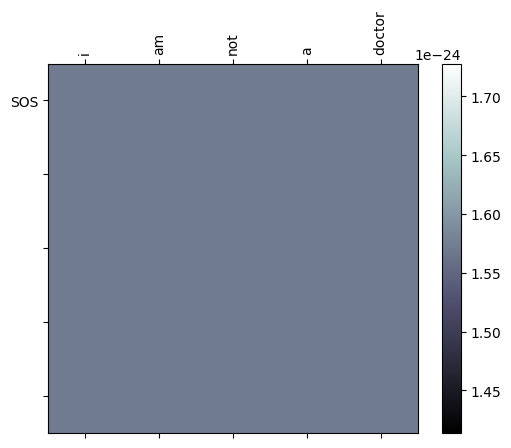

In [ ]:
evaluateAndShowAttention('i am not a doctor but a teacher', encoder_att, decoder_att, filtered_dataset)

We played here with a dataset but did not rigorously evaluate. The usual metric for Machine Translation is the [**BLEU Score**](https://aclanthology.org/P02-1040.pdf). You can find existing implementations, for example in [Huggingface](https://huggingface.co/spaces/evaluate-metric/bleu). Rigorously experiment with
- A model with attention
- A model without attention

and use the BLEU score on the test set to compare them.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
!pip install nltk
import torch
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def compute_bleu(encoder, decoder, test_dataloader, dataset):
    references = []
    hypotheses = []

    for batch in test_dataloader:
        input_tensor, target_tensor = batch
        input_sentences = [
            [dataset.input_lang.idx2word[idx.item()] for idx in input_tensor[0] if idx.item() not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]
        ]
        target_sentences = [
            [dataset.output_lang.idx2word[idx.item()] for idx in target_tensor[0] if idx.item() not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]
        ]

        output_words, _ = evaluate(encoder, decoder, " ".join(input_sentences[0]), dataset.max_length, dataset.input_lang, dataset.output_lang)
        hypotheses.append(output_words)
        references.append(target_sentences)

    return corpus_bleu(references, hypotheses)

In [ ]:
bleu_no_att = compute_bleu(encoder, decoder, testing_dataloader, filtered_dataset)
print(f"BLEU Score (No Attention): {bleu_no_att:.4f}")
bleu_att = compute_bleu(encoder_att, decoder_att, testing_dataloader, filtered_dataset)
print(f"BLEU Score (With Attention): {bleu_att:.4f}")

BLEU Score (No Attention): 0.0326
BLEU Score (With Attention): 0.0971


<div class='alert alert-block alert-warning'>
            Question:</div>
            
We improved our initial model with attention. But considering our goal is to **generate text**, we should work on **decoding**. How would you go about implementing that given our current code ? Where is the ideal place to add a decoding function ?



<div class='alert alert-block alert-warning'>
            Answer:</div>
To improve text generation, we need a more effective decoding strategy beyond simple greedy decoding. Beam Search is a strong alternative because it considers multiple candidate sequences at each step, leading to more fluent and accurate translations.

Implementation Approach:

- We should modify the current decoding process in the AttentionDecoderRNN model.

- Instead of greedy decoding (choosing the highest probability word at each step), we should implement Beam Search to explore multiple translation paths.

Ideal Place to Add the Decoding Function:

-The best place to add Beam Search is inside the *evaluate()* function, which is responsible for generating output sentences.

- This function currently uses greedy decoding by selecting the highest-probability word at each step.

- By replacing it with Beam Search, the model will consider multiple translation paths, improving fluency and accuracy.

Propose a modification of the *relevant function* in this lab in which to include **Beam search**, following the code you used in the previous lab. Similarly as before, compare the BLEU score of:
- A model decoding with Beam search
- A model using simple greedy decoding

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def evaluate_with_beam_search(encoder, decoder, sentence, max_length, input_lang, output_lang, beam_width=5):
    """
    New function: Implements Beam Search decoding.
    """
    encoder.eval()
    decoder.eval()

    input_tensor = tensorFromSentence(sentence, input_lang, max_length).view(1, -1).to(device)
    encoder_outputs, encoder_hidden = encoder(input_tensor)

    decoder_hidden = encoder_hidden
    decoder_input = torch.tensor([[SOS_TOKEN]], dtype=torch.long, device=device)

    sequences = [(0.0, [SOS_TOKEN], decoder_hidden)]  # (score, sequence, hidden_state)

    for _ in range(max_length):
        all_candidates = []
        for score, seq, hidden in sequences:
            decoder_input = torch.tensor([[seq[-1]]], dtype=torch.long, device=device)
            decoder_output, hidden, _ = decoder(encoder_outputs, hidden, 1, decoder_input)

            log_probs, indices = torch.topk(decoder_output[0, -1], beam_width)
            for i in range(beam_width):
                word_idx = indices[i].item()
                new_score = score + log_probs[i].item()
                candidate = (new_score, seq + [word_idx], hidden)
                all_candidates.append(candidate)

        sequences = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:beam_width]

    best_sequence = sequences[0][1]
    decoded_words = [output_lang.idx2word[idx] for idx in best_sequence if idx != EOS_TOKEN]

    return decoded_words


In [ ]:
def evaluate(encoder, decoder, sentence, max_length, input_lang, output_lang):
    """
    Unified version: Combines both step-by-step decoding and attention tracking.
    """
    encoder.eval()
    decoder.eval()

    # Prepare input tensor
    input_tensor = tensorFromSentence(sentence, input_lang, max_length).view(1, -1).to(device)

    # Forward through encoder
    encoder_outputs, encoder_hidden = encoder(input_tensor)

    decoder_hidden = encoder_hidden
    decoder_input = torch.tensor([[SOS_TOKEN]], dtype=torch.long, device=device)

    decoded_words = []
    attention_weights = []

    for _ in range(max_length):
        decoder_output, decoder_hidden, attn_weights = decoder(encoder_outputs, decoder_hidden, 1, decoder_input)

        topv, topi = decoder_output.topk(1)  # Get top predicted word index
        if topi.item() == EOS_TOKEN:
            break

        decoded_words.append(output_lang.idx2word[topi.item()])  # Convert index to word
        attention_weights.append(attn_weights.squeeze(0).cpu().detach().numpy())  # Store attention for visualization

        decoder_input = topi.detach().view(1, -1)  # Update input for next step

    return decoded_words, torch.tensor(attention_weights)


In [ ]:
print("Sample Output - Greedy Decoding:")
output_greedy, _ = evaluate(encoder_att, decoder_att, "i am happy", filtered_dataset.max_length, filtered_dataset.input_lang, filtered_dataset.output_lang)
print(" ".join(output_greedy))

print("\nSample Output - Beam Search:")
output_beam = evaluate_with_beam_search(encoder_att, decoder_att, "i am happy", filtered_dataset.max_length, filtered_dataset.input_lang, filtered_dataset.output_lang, beam_width=5)
print(" ".join(output_beam))


Sample Output - Greedy Decoding:
SOS

Sample Output - Beam Search:
SOS SOS j'ai es es es es es es


In [ ]:
def compute_bleu_for_decoding_methods(encoder, decoder, test_dataloader, dataset, beam_width=5):
    """
    Computes BLEU scores for Greedy Decoding (beam_width=1) vs. Beam Search.
    """
    references = []
    hypotheses_greedy = []
    hypotheses_beam = []

    for batch in test_dataloader:
        input_tensor, target_tensor = batch

        # Convert input tensor to words
        input_sentences = [
            [dataset.input_lang.idx2word[idx.item()] for idx in input_tensor[0] if idx.item() not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]
        ]
        # Convert target tensor to reference words
        target_sentences = [
            [dataset.output_lang.idx2word[idx.item()] for idx in target_tensor[0] if idx.item() not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]
        ]

        # Greedy Decoding (beam_width=1)
        output_words_greedy, _ = evaluate(encoder, decoder, " ".join(input_sentences[0]), dataset.max_length, dataset.input_lang, dataset.output_lang)
        hypotheses_greedy.append(output_words_greedy)

        # Beam Search Decoding (beam_width > 1)
        output_words_beam = evaluate_with_beam_search(encoder, decoder, " ".join(input_sentences[0]), dataset.max_length, dataset.input_lang, dataset.output_lang, beam_width)
        hypotheses_beam.append(output_words_beam)

        references.append(target_sentences)

    # Compute BLEU scores
    bleu_greedy = corpus_bleu(references, hypotheses_greedy)
    bleu_beam = corpus_bleu(references, hypotheses_beam)

    return bleu_greedy, bleu_beam

In [ ]:
# Compute BLEU scores for Greedy vs. Beam Search
bleu_greedy, bleu_beam = compute_bleu_for_decoding_methods(encoder_att, decoder_att, testing_dataloader, filtered_dataset, beam_width=5)

# Print results
print(f"BLEU Score (Greedy Decoding): {bleu_greedy:.4f}")
print(f"BLEU Score (Beam Search, beam_width=5): {bleu_beam:.4f}")

<ipython-input-37-209e6024455b>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return decoded_words, torch.tensor(attention_weights)


BLEU Score (Greedy Decoding): 0.0000
BLEU Score (Beam Search, beam_width=5): 0.0000


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Find a model on [Huggingface](https://huggingface.co/tasks/translation) for this task. Try to **understand what model it is** - and who trained it, on which data. Apply it to the same dataset and compute the BLEU score.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
!pip install transformers sentencepiece torch
from transformers import MarianMTModel, MarianTokenizer

In [ ]:
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)